# CO3093 CW

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn import svm, feature_selection, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

## Part 1

### Data Cleaning

In [2]:
df = pd.read_csv('Manhattan12.csv')

#Identifying numerical and categorical variables
categorical_variables = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',\
                        'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT', 'BUILDING CLASS AT PRESENT',\
                            'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'YEAR BUILT', 'BUILDING CLASS AT TIME OF SALE',\
                            'SALE DATE', 'TAX CLASS AT TIME OF SALE']
numerical_variables = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS',\
                        'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE']


def clean_Manhattan12_df(df=df, categorical_variables=categorical_variables, numerical_variables=numerical_variables):
    print('Initial Dataset shape: {} \n'.format(df.shape))
    print('Starting DF cleaning...')
    
    #Initial formatting
    column_names = df.loc[3, :].values.tolist()
    df.drop(df.index[:4], inplace=True)
    df = df.set_axis(column_names, axis=1, copy=False)
    df.rename(columns={'APART\nMENT\nNUMBER' : 'APARTMENT NUMBER', 'SALE\nPRICE' : 'SALE PRICE'}, inplace=True) #Rename columns correctly
    df.reset_index(drop=True, inplace=True)
    print('Dataset shape after correctly formatting the columns: {} \n'.format(df.shape))

    # Removing '$' and ',' from sale price and convert numerical columns to numeric 
    df['SALE PRICE'].replace('[\$,]', '', regex=True, inplace=True)
    for col in numerical_variables:
        df[col].replace('[\$,]', '', regex=True, inplace=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], dayfirst = True) #Change sale date type to datetime

    #Remove spaces and replace empty spaces with NaN for categorical variables
    for col in categorical_variables:
        if col == 'SALE DATE':
            continue
        df[col] = df[col].str.strip()
        df[col].replace('', np.nan, inplace=True)
        df[col] = df[col].astype(object, copy=False)

    #Replace 0 with NaN for certain numerical columns
    for col in numerical_variables:
        df[col] = df[col].replace(0, np.nan)    
    df['YEAR BUILT'].replace('0', np.nan, inplace = True)

    print('Summary of missing values: \n{} \n'.format(pd.isnull(df).sum())) #Shows number of missing values for each column
    print('Summary statistics: \n{} \n'.format(df.describe())) #Shows summary statistics

    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT NUMBER'], inplace=True) #Drop certain columns

    df.drop_duplicates(inplace = True, ignore_index = True) #Drop duplicates

    print('Dataset shape after removing duplicates and 3 columns: {}\n'.format(df.shape))

    df.dropna(how='any', inplace=True) #Drop rows with any values as NaN
    
    print('Dataset shape after removing entities containing Nan Values; {}\n'.format(df.shape))
    print('DF cleaning done\n')

    return df
    
#Visualise the outliers to set the threshold in removing_outliers function
def visualise_outliers(data=df):
    print('Visualising outliers...')
    
    plt.figure()
    sns.boxplot(data=df, x='SALE PRICE', y='BUILDING CLASS CATEGORY', orient='h')

    plt.figure()
    sns.boxplot(data=df, x='TOTAL UNITS', y='BUILDING CLASS CATEGORY', orient='h')

    plt.figure()
    sns.boxplot(data=df, x='LAND SQUARE FEET', y='BUILDING CLASS CATEGORY', orient='h')

    plt.figure()
    sns.boxplot(data=df, x='GROSS SQUARE FEET', y='BUILDING CLASS CATEGORY', orient='h')

    plt.figure()
    sns.boxplot(data=df, x='RESIDENTIAL UNITS', y='BUILDING CLASS CATEGORY', orient='h')
    
    plt.figure()
    sns.boxplot(data=df, x='COMMERCIAL UNITS', y='BUILDING CLASS CATEGORY', orient='h')
    
    return 'DONE\n'

def remove_outlier(df):
    print('Removing outliers...')
    temp = np.zeros(df.shape[0])
    for i, x in enumerate(df['SALE PRICE']):
        if (x > 100000000): temp[i] = 1 
    for i, x in enumerate(df['TOTAL UNITS']):
        if (x > 300): temp[i] = 1 
    for i, x in enumerate(df['LAND SQUARE FEET']):
        if (x > 40000): temp[i] = 1
    for i, x in enumerate(df['GROSS SQUARE FEET']):
        if (x > 400000): temp[i] = 1
    for i, x in enumerate(df['COMMERCIAL UNITS']):
        if (x > 15): temp[i] = 1
    for i, x in enumerate(df['RESIDENTIAL UNITS']):
        if (x > 300): temp[i] = 1
    df['temp'] = temp
    df = df[df.temp == 0]
    df.drop('temp', axis = 1, inplace = True)
    print('Dataset shape after removing outliers: {}\nDONE\n'.format(df.shape))
    return df

def normalise(df = df):
    print('Normalising DF...')
    df_norm = df.copy()
    num_var = numerical_variables.copy()
    num_var.append('LOG_PRICE')
    for col in num_var:
        df_norm[col] = ((df_norm[col]-df_norm[col].min())/(df_norm[col].max()-df_norm[col].min()))
    print('DF normalised')
    return df_norm

Initial Dataset shape: (27399, 21) 

Starting DF cleaning...
Dataset shape after correctly formatting the columns: (27395, 21) 

Summary of missing values: 
BOROUGH                               0
NEIGHBORHOOD                         17
BUILDING CLASS CATEGORY            3454
TAX CLASS AT PRESENT                143
BLOCK                                 0
LOT                                   0
EASE-MENT                         27395
BUILDING CLASS AT PRESENT           143
ADDRESS                               0
APARTMENT NUMBER                  14570
ZIP CODE                              0
RESIDENTIAL UNITS                 16372
COMMERCIAL UNITS                  23962
TOTAL UNITS                        9704
LAND SQUARE FEET                  22906
GROSS SQUARE FEET                 23069
YEAR BUILT                         6441
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                         7593
SALE DATE                             0
dty

/var/folders/3r/lm1h5j9n0nj2wblsnb5prwq00000gn/T/ipykernel_27507/3826476265.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('temp', axis = 1, inplace = True)


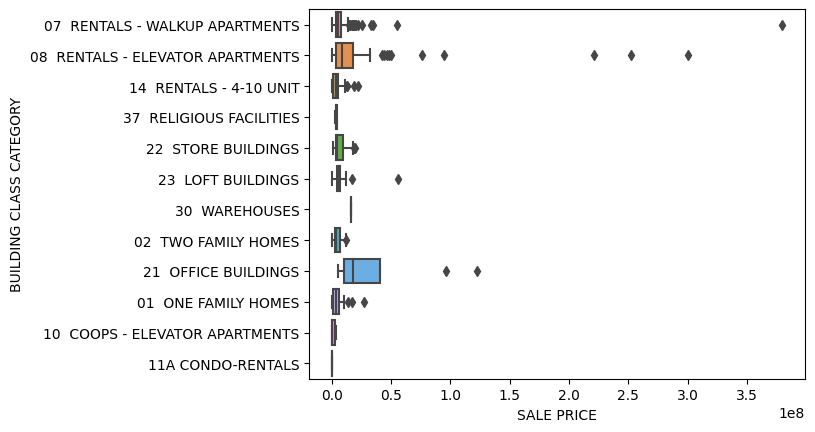

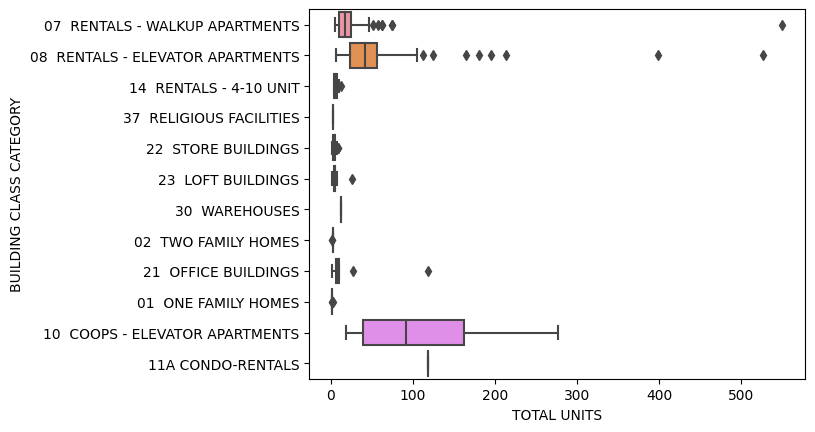

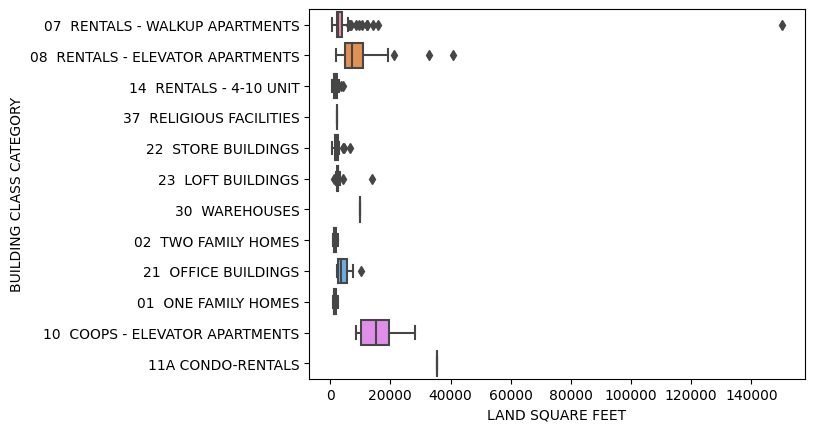

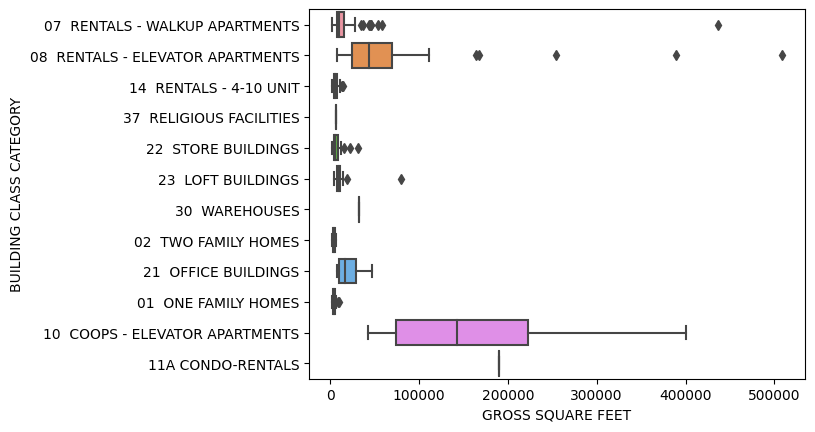

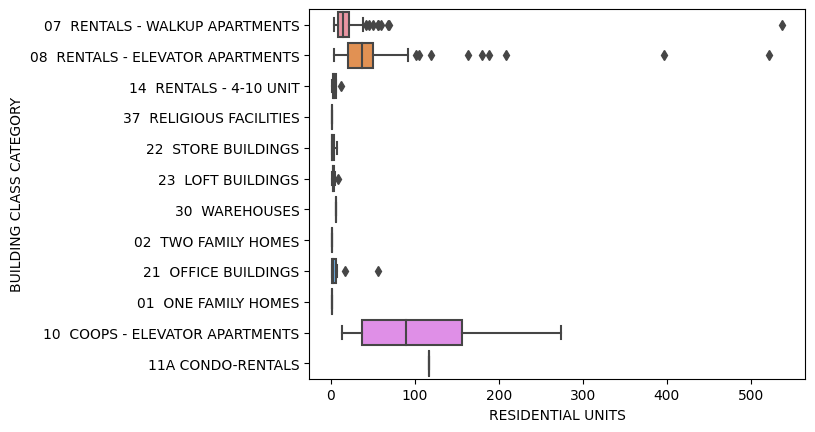

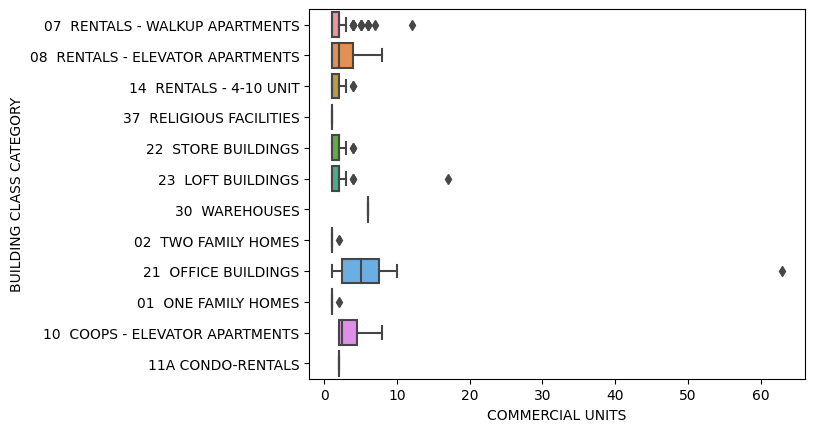

In [3]:
#Initial CSV clean
df = pd.read_csv('Manhattan12.csv')

df = clean_Manhattan12_df(df)

visualise_outliers(df)#Visualise outliers using boxplot

df = remove_outlier(df) #Remove outliers

df['LOG_PRICE'] = np.log(df['SALE PRICE']) #Create LOG_PRICE column

df_norm = normalise(df) #Normalise DF

print('Final Dataset shape after adding LOG_PRICE column: {} \n'.format(df.shape))

### Data Exploration

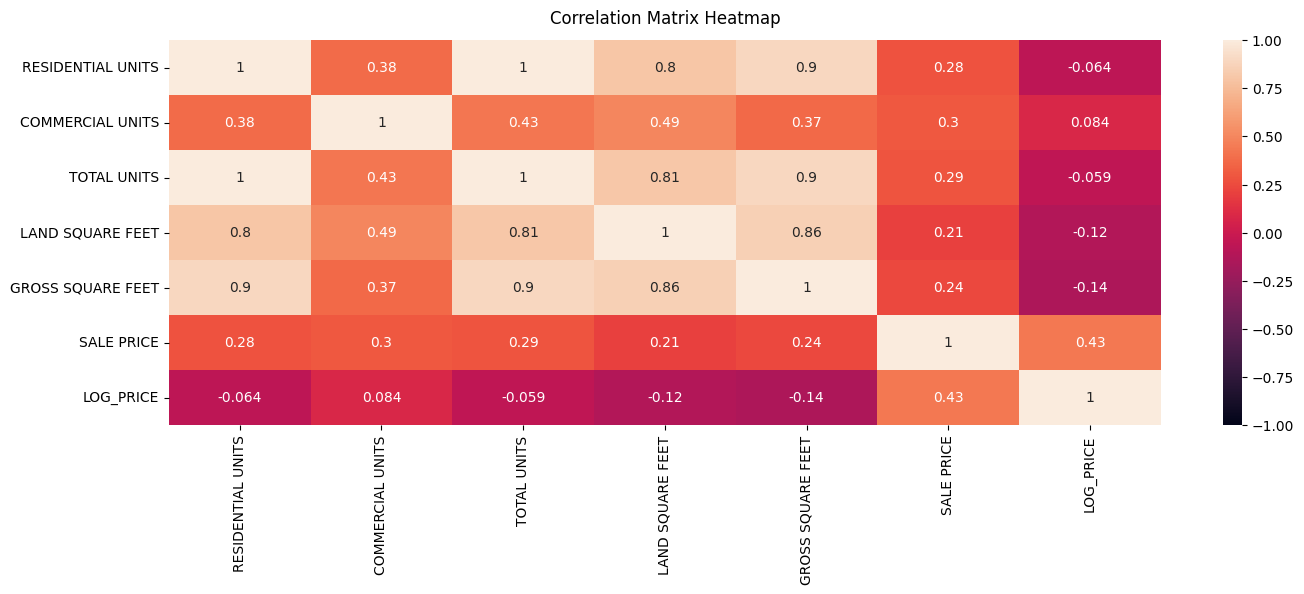

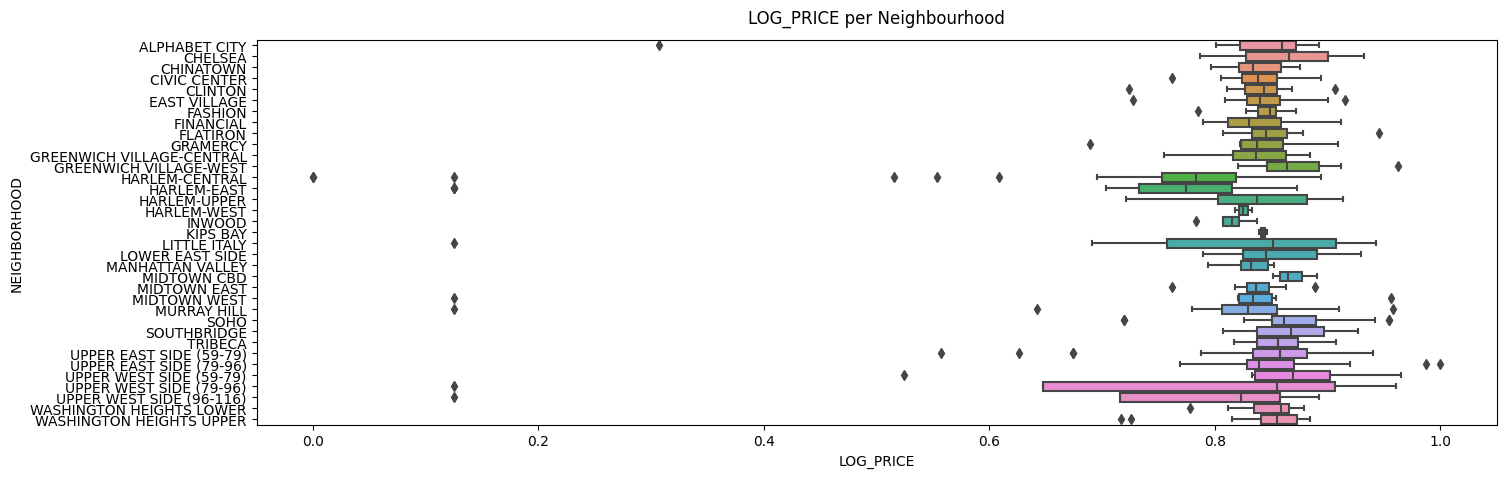

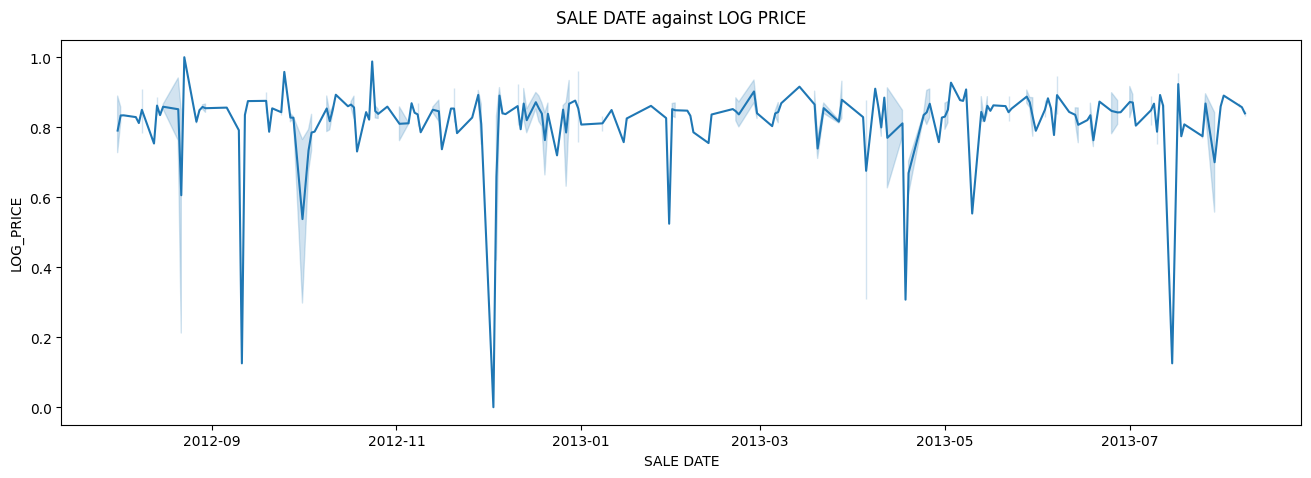

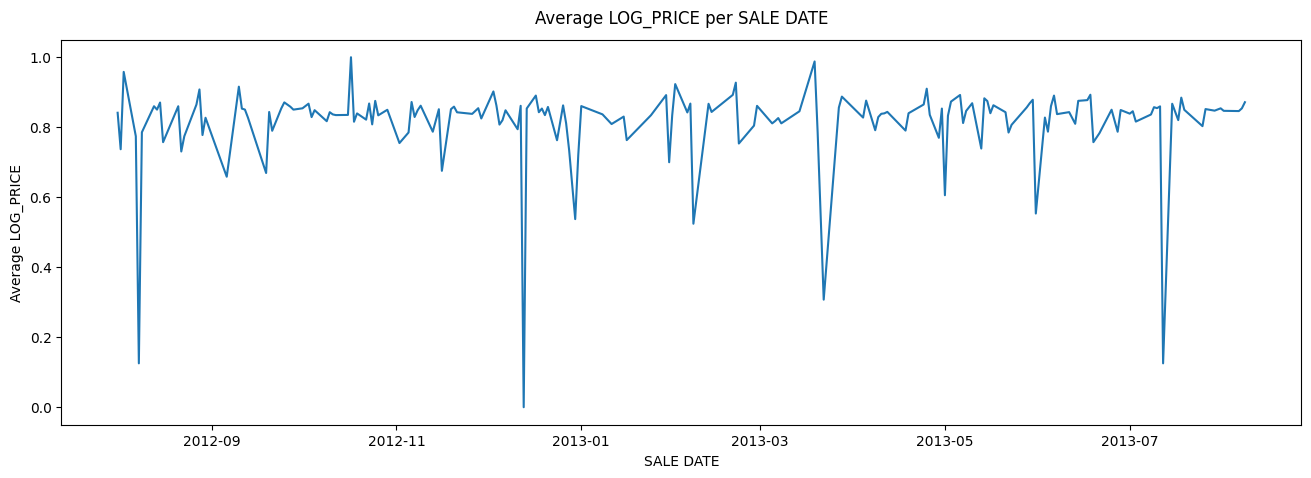

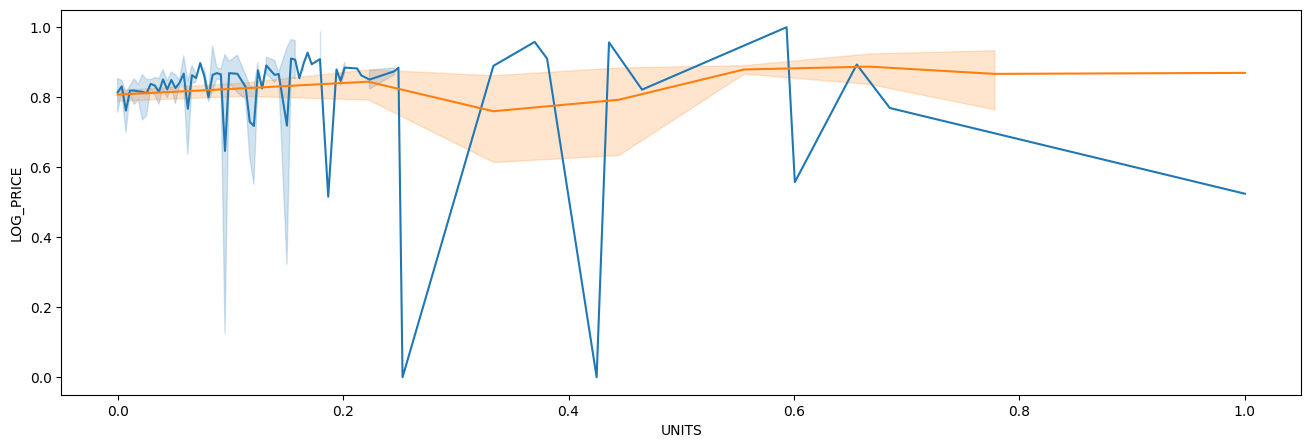

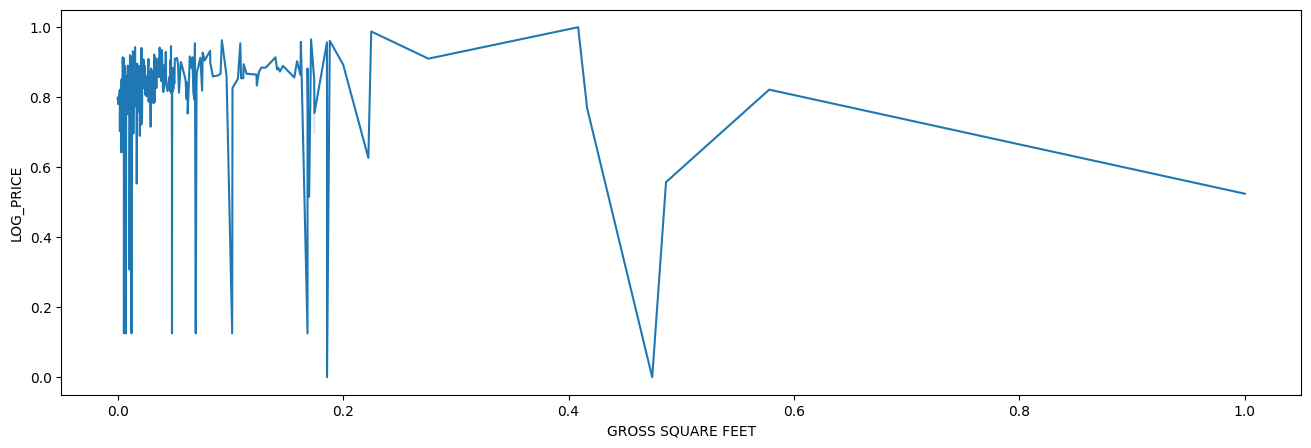

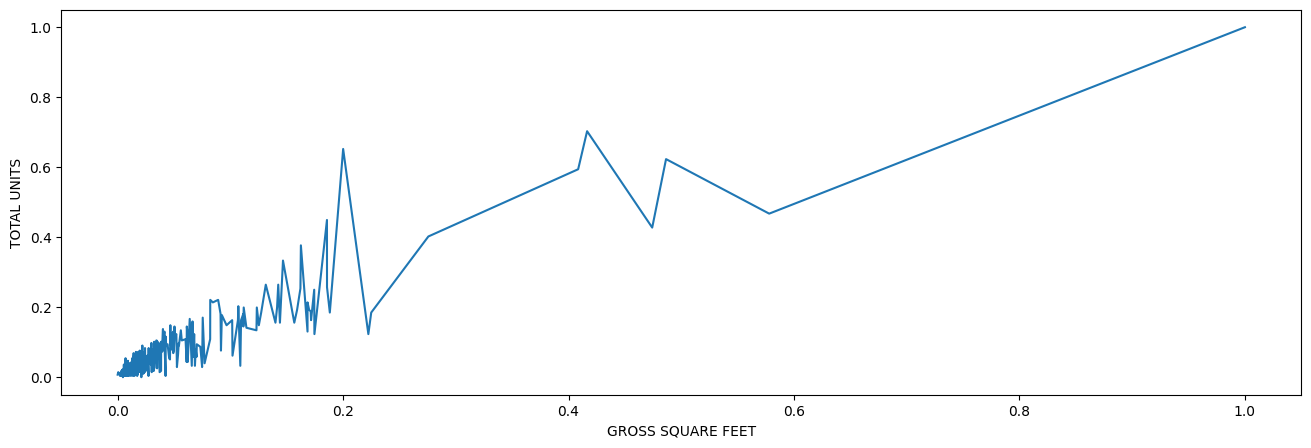

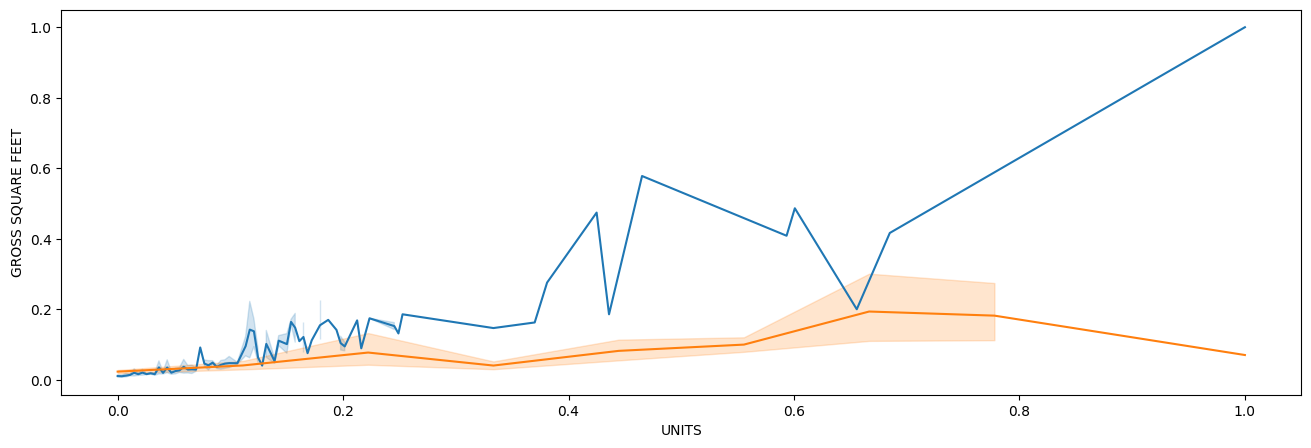

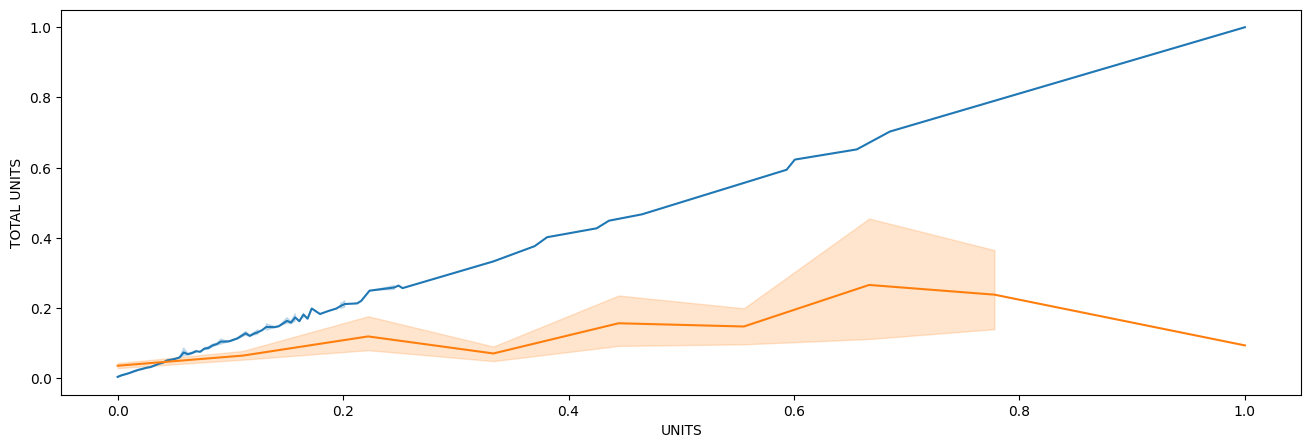

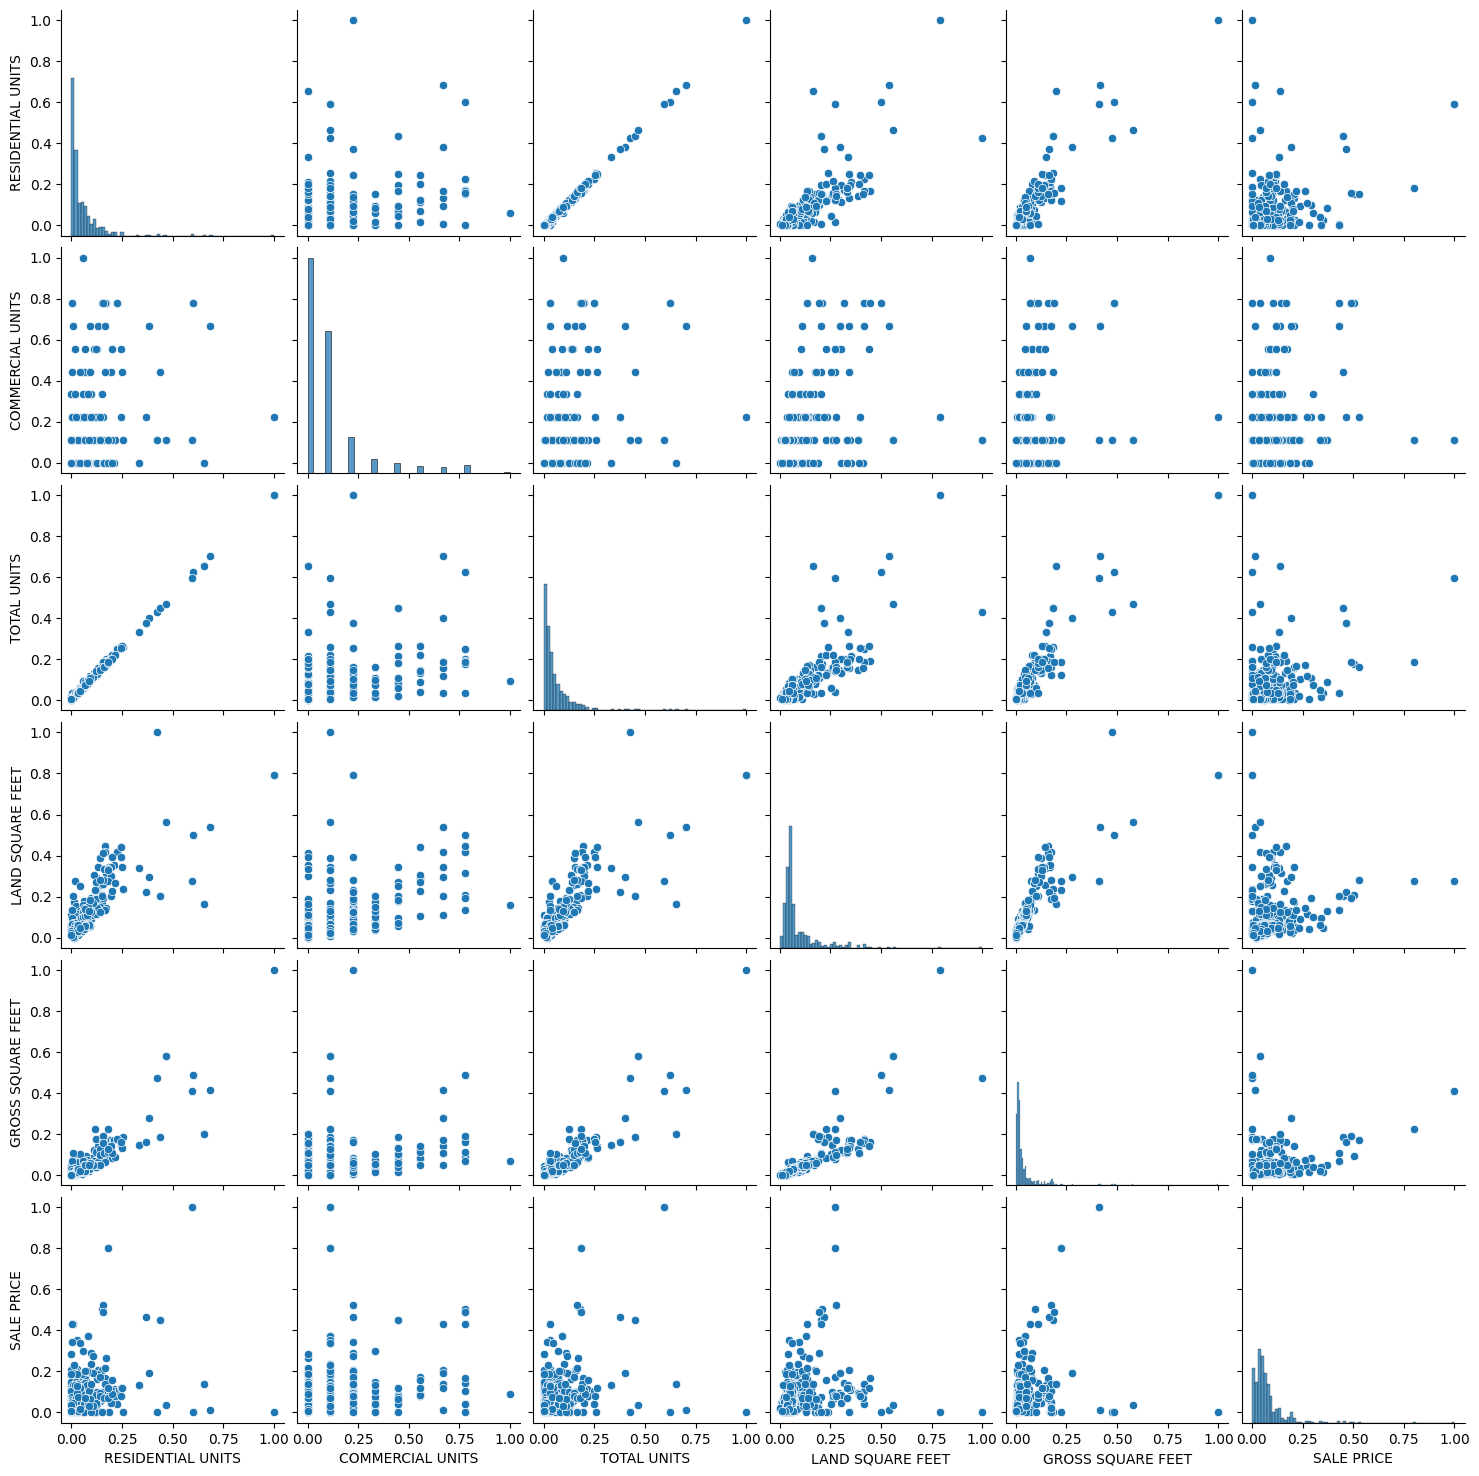

In [4]:
def boxplot_log_price_x_neighborhood(df=df_norm):
    plt.figure(figsize=(16, 5))
    graph1 = sns.boxplot(data=df, orient='h', x='LOG_PRICE', y='NEIGHBORHOOD')
    graph1.set_title('LOG_PRICE per Neighbourhood', fontdict={'fontsize':12}, pad=12)

def lineplot_x_against_SALE_PRICE(x, df=df_norm):
    plt.figure(figsize=(16, 5))
    graph2 = sns.lineplot(data=df_norm, x=x, y="LOG_PRICE")
    graph2.set_title(x+' against LOG PRICE', fontdict={'fontsize':12}, pad=12)

def correlation_matrix_heatmap(df):
    plt.figure(figsize=(16, 5))
    heatmap = sns.heatmap(df.corr(numeric_only = True), vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Matrix Heatmap', fontdict={'fontsize':12}, pad=12)
    
def lineplot_avprice_against_SALEDATE(df):
    x = df_norm['SALE DATE'].unique()
    y =  df_norm['LOG_PRICE'].groupby(df_norm['SALE DATE']).mean()
    plt.figure(figsize=(16, 5))
    graph3 = sns.lineplot(x=x, y=y)
    graph3.set(ylabel='Average LOG_PRICE', xlabel="SALE DATE")
    graph3.set_title('Average LOG_PRICE per SALE DATE', fontdict={'fontsize':12}, pad=12)

correlation_matrix_heatmap(df_norm) #Correlation matrix heatmap
boxplot_log_price_x_neighborhood()
lineplot_x_against_SALE_PRICE('SALE DATE')
lineplot_avprice_against_SALEDATE(df_norm)

plt.figure(figsize=(16, 5))
graph2 = sns.lineplot(data=df_norm, x='RESIDENTIAL UNITS', y="LOG_PRICE")
graph2 = sns.lineplot(data=df_norm, x='COMMERCIAL UNITS', y="LOG_PRICE")
graph2.set(xlabel='UNITS')

plt.figure(figsize=(16, 5))
sns.lineplot(data=df_norm, x='GROSS SQUARE FEET', y='LOG_PRICE')

plt.figure(figsize=(16, 5))
sns.lineplot(data=df_norm, x='GROSS SQUARE FEET', y='TOTAL UNITS')

plt.figure(figsize=(16, 5))
graph3 = sns.lineplot(data=df_norm, x='RESIDENTIAL UNITS', y='GROSS SQUARE FEET')
graph3 = sns.lineplot(data=df_norm, x='COMMERCIAL UNITS', y='GROSS SQUARE FEET')
graph3.set(xlabel='UNITS')

plt.figure(figsize=(16, 5))
graph4 = sns.lineplot(data=df_norm, x='RESIDENTIAL UNITS', y='TOTAL UNITS', legend='brief')
graph4 = sns.lineplot(data=df_norm, x='COMMERCIAL UNITS', y='TOTAL UNITS', legend='brief')
graph4.set(xlabel='UNITS')

sns.pairplot(df_norm[numerical_variables]) #Scatter plot matrix for numerical columns

### Model Building

In [5]:
def select_model_features(df, n):  
    df_copy = df.select_dtypes(include=[np.number]).copy() #Copy df numerical columns
    
    cols = df_copy.columns.values.tolist()
    cols.remove('LOG_PRICE')
    cols.remove('SALE PRICE')
    
    X = df_copy[cols]
    Y = df_copy['LOG_PRICE'] #Column to predict
    estimator = svm.SVR(kernel="linear")
    selector = feature_selection.RFE(estimator, n_features_to_select=n, step=1)
    selector = selector.fit(X, Y)
    select_features = np.array(cols)[selector.ranking_ == 1].tolist()
    
    print('These are the features used to predict: \n{}\nDONE\n'.format(select_features))
    return select_features

select_features = select_model_features(df_norm, 4)

def linear_model_build(df, select_features):
    df_copy = df.select_dtypes(include=[np.number]).copy() #Copy df numerical columns
    
    X = df_copy[select_features]
    Y = df_copy['LOG_PRICE']
    
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2) #Split data into a train set and test set
    
    lm = linear_model.LinearRegression()
    lm.fit(trainX, trainY) #Train the Linear Regression Model
    
    pred_testY = lm.predict(testX)
    residuals = testY - pred_testY
    hist = sns.histplot(residuals)
    hist.set(xlabel='Residuals', ylabel='Count') #Graph of the residuals
    
    print("Y-axis intercept {:6.4f}\n".format(lm.intercept_))
    print("Coefficients:")
    for feat, coef in zip(select_features, lm.coef_):
        print(" {:>20}: {:6.4f}".format(feat, coef))
    print("\nR squared for the training data: {:4.3f}\n".format(lm.score(trainX, trainY)))
    print("R squared for the test data: {:4.3f}".format(lm.score(testX, testY)))
    print('Mean square error (MSE): {}\n'.format(mean_squared_error(testY, pred_testY, squared=True)))
    crossvalidation = KFold(8,shuffle=True, random_state=0)
    cv = cross_val_score(lm, X, Y,scoring='r2',cv=crossvalidation, n_jobs=-1)
    print("Cross Validation r2 score: {:5.4f}\nDONE".format(np.mean(cv)))

These are the features used to predict: 
['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']
DONE



Y-axis intercept 0.8127

Coefficients:
    RESIDENTIAL UNITS: 0.1865
     COMMERCIAL UNITS: 0.1002
     LAND SQUARE FEET: 0.1690
    GROSS SQUARE FEET: -0.6047

R squared for the training data: 0.052

R squared for the test data: -0.013
Mean square error (MSE): 0.035959082278453056

Cross Validation r2 score: -0.0469
DONE


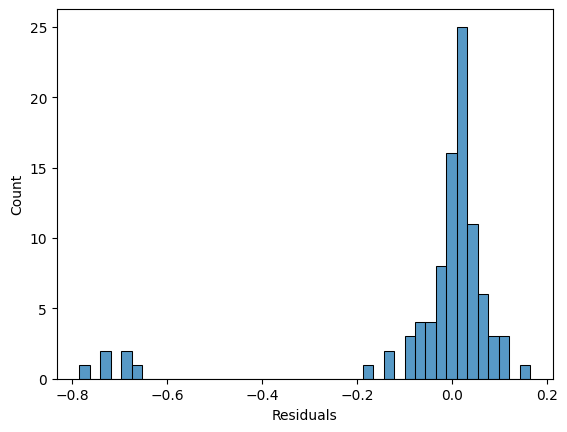

In [6]:
linear_model_build(df_norm, select_features)

## Part 2 - Improved Model

In [7]:
df = pd.read_csv('Manhattan12.csv')

def improved_df_cleaning(df=df, categorical_variables=categorical_variables, numerical_variables=numerical_variables):
    print('Initial Dataset shape: {} \n'.format(df.shape))
    print('Starting Dataset cleaning...')
    column_names = df.loc[3, :].values.tolist()
    df.drop(df.index[:4], inplace=True)
    df = df.set_axis(column_names, axis=1, copy=False)
    df.rename(columns={'APART\nMENT\nNUMBER' : 'APARTMENT NUMBER', 'SALE\nPRICE' : 'SALE PRICE'}, inplace=True) #Rename columns correctly
    df.reset_index(drop=True, inplace=True)
    print('Dataset shape after correctly formatting the columns: {} \n'.format(df.shape))

    # Removing '$' and ',' from sale price and convert numerical columns to numeric 
    df['SALE PRICE'].replace('[\$,]', '', regex=True, inplace=True)
    for col in numerical_variables:
        df[col].replace('[\$,]', '', regex=True, inplace=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], dayfirst = True) #Change sale date type to datetime

    #Remove spaces and replace empty spaces with NaN for categorical variables
    for col in categorical_variables:
        if col == 'SALE DATE':
            continue
        df[col] = df[col].str.strip()
        df[col].replace('', np.nan, inplace=True)
        df[col] = df[col].astype(object, copy=False)

    #Replace 0 with NaN for certain numerical columns
    for col in numerical_variables:
        df[col] = df[col].replace(0, np.nan)    
    df['YEAR BUILT'].replace('0', np.nan, inplace = True)

    print('Summary of missing values: \n{} \n'.format(pd.isnull(df).sum())) #Shows number of missing values for each column
    print('Summary statistics: \n{} \n'.format(df.describe())) #Shows summary statistics

    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT NUMBER'], inplace=True) #Drop certain columns
    
    updated_categorical_variables = ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',\
                        'TAX CLASS AT PRESENT', 'BLOCK', 'LOT','BUILDING CLASS AT PRESENT',\
                            'ADDRESS','ZIP CODE', 'YEAR BUILT', 'BUILDING CLASS AT TIME OF SALE',\
                            'SALE DATE', 'TAX CLASS AT TIME OF SALE']

    df.drop_duplicates(inplace = True, ignore_index = True) #Drop duplicates

    print('Dataset shape after removing duplicates and 3 columns: {}\n'.format(df.shape))

    df.dropna(how='all', inplace=True) #Drop rows with all values as NaN
    #df.dropna(how='any', subset=['SALE PRICE'], inplace=True) #Drop rows with all values as NaN in SALE PRICE column
    
    #Covert categorical Variables to numeric
    #This section is commented out because of the GREAT increase
    #in computational power needed when using RFE if this is performed.
    '''for col in updated_categorical_variables:
        df[col] = df[col].astype('category') 
    df[updated_categorical_variables] = df[updated_categorical_variables].apply(lambda x: x.cat.codes)'''
    
    print('Dataset shape after converting categorical variables to numerical: {}\n'.format(df.shape))
        
    print('Dataset shape after removing entities containing all NaN Values; {}\n'.format(df.shape))
    
    print('Dataset cleaning done\n')
    
    return df

def impute_df(df):
    '''Predicts NaN values and replaces them
    Oututs: df of only numerical columns'''
    
    print('Initial summary of missing values: \n{} \n'.format(pd.isnull(df).sum())) #Shows number of missing values for each column
    
    df_copy = df.select_dtypes(include=[np.number]).copy() #Copy df numerical columns
    imputer = IterativeImputer(estimator=linear_model.LinearRegression(), missing_values=np.nan)
    imputer.fit(df_copy)
    
    df_imputed = pd.DataFrame(data = imputer.transform(df_copy), columns = df_copy.columns) #Put imputer output into dataframe
    
    print('FINAL summary of missing values: \n{} \n'.format(pd.isnull(df_imputed).sum())) #Shows number of missing values for each column

    return df_imputed
    
def improved_model(df):
    #This model uses all features columns to predict
    #If cateforical variables are converted to numeric it will use all the features
    #Otherwise just numerical features
    
    print('Creating model...')
        
    cols = df.columns.values.tolist()
    cols.remove('LOG_PRICE')
    cols.remove('SALE PRICE')
    
    Y = df['LOG_PRICE'] #Column to predict
    X = df[cols] #Columns used to predict
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2) #Split data into a train set and test set
    lm = linear_model.LinearRegression(n_jobs=-1)
    lm.fit(trainX, trainY) #Train the Linear Regression Model
    
    pred_testY = lm.predict(testX)
    residuals = testY - pred_testY
    hist = sns.histplot(residuals)
    hist.set(xlabel='Residuals', ylabel='Count') #Graph of the residuals
    
    #Output Stats
    print("Y-axis intercept {:6.4f}\n".format(lm.intercept_))
    print("Coefficients:")
    for feat, coef in zip(cols, lm.coef_):
        print(" {:>20}: {:6.4f}".format(feat, coef))
    print("\nR squared for the training data: {:4.3f}\n".format(lm.score(trainX, trainY)))
    print("R squared for the test data: {:4.3f}\n".format(lm.score(testX, testY)))
    print('Mean square error (MSE): {}\n'.format(mean_squared_error(testY, pred_testY, squared=True)))    
    crossvalidation = KFold(8,shuffle=True, random_state=0)
    cv = cross_val_score(lm, X, Y,scoring='r2',cv=crossvalidation, n_jobs=-1)
    print("Cross Validation r2 score: {:5.4f}".format(np.mean(cv))) 
    
    return 'DONE'

def improved_model2(df):
    #This model uses RFE to select 4 features and uses those
    
    print('Creating model...')
        
    select_features = select_model_features(df, 4)
    
    Y = df['LOG_PRICE'] #Column to predict
    X = df[select_features] #Columns used to predict
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2) #Split data into a train set and test set
    lm = linear_model.LinearRegression(n_jobs=-1)
    lm.fit(trainX, trainY) #Train the Linear Regression Model
    
    pred_testY = lm.predict(testX)
    residuals = testY - pred_testY
    hist = sns.histplot(residuals)
    hist.set(xlabel='Residuals', ylabel='Count')
    
    #Output Stats
    print("Y-axis intercept {:6.4f}\n".format(lm.intercept_))
    print("Coefficients:")
    for feat, coef in zip(select_features, lm.coef_):
        print(" {:>20}: {:6.4f}".format(feat, coef))
    print("\nR squared for the training data: {:4.3f}\n".format(lm.score(trainX, trainY)))
    print("R squared for the test data: {:4.3f}\n".format(lm.score(testX, testY)))
    print('Mean square error (MSE): {}\n'.format(mean_squared_error(testY, pred_testY, squared=True)))
    crossvalidation = KFold(8,shuffle=True, random_state=0)
    cv = cross_val_score(lm, X, Y,scoring='r2',cv=crossvalidation, n_jobs=-1)
    print("Cross Validation r2 score: {:5.4f}".format(np.mean(cv))) 
    
    return 'DONE'
    
def improved_model3(df):
    #This model uses hand-picked columns to predict
    
    cols = ['TAX CLASS AT PRESENT', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'TAX CLASS AT TIME OF SALE', 'BLOCK']
    
    Y = df['LOG_PRICE'] #Column to predict
    X = df[cols] #Columns used to predict
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2) #Split data into a train set and test set
    lm = linear_model.LinearRegression(n_jobs=-1)
    lm.fit(trainX, trainY) #Train the Linear Regression Model
    
    pred_testY = lm.predict(testX)
    residuals = testY - pred_testY
    hist = sns.histplot(residuals)
    hist.set(xlabel='Residuals', ylabel='Count')
    
    #Output Stats
    print("Y-axis intercept {:6.4f}\n".format(lm.intercept_))
    print("Coefficients:")
    for feat, coef in zip(cols, lm.coef_):
        print(" {:>20}: {:6.4f}".format(feat, coef))
    print("\nR squared for the training data: {:4.3f}\n".format(lm.score(trainX, trainY)))
    print("R squared for the test data: {:4.3f}\n".format(lm.score(testX, testY)))
    print('Mean square error (MSE): {}\n'.format(mean_squared_error(testY, pred_testY, squared=True)))
    crossvalidation = KFold(8,shuffle=True, random_state=0)
    cv = cross_val_score(lm, X, Y,scoring='r2',cv=crossvalidation, n_jobs=-1)
    print("Cross Validation r2 score: {:5.4f}".format(np.mean(cv))) 
    
    return 'DONE'


In [8]:
df = improved_df_cleaning(df)

df['LOG_PRICE'] = np.log(df['SALE PRICE']) #Create LOG_PRICE column

df = remove_outlier(df) #Remove outliers

df_norm = normalise(df) #Normalise DF

Initial Dataset shape: (27399, 21) 

Starting Dataset cleaning...
Dataset shape after correctly formatting the columns: (27395, 21) 

Summary of missing values: 
BOROUGH                               0
NEIGHBORHOOD                         17
BUILDING CLASS CATEGORY            3454
TAX CLASS AT PRESENT                143
BLOCK                                 0
LOT                                   0
EASE-MENT                         27395
BUILDING CLASS AT PRESENT           143
ADDRESS                               0
APARTMENT NUMBER                  14570
ZIP CODE                              0
RESIDENTIAL UNITS                 16372
COMMERCIAL UNITS                  23962
TOTAL UNITS                        9704
LAND SQUARE FEET                  22906
GROSS SQUARE FEET                 23069
YEAR BUILT                         6441
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                         7593
SALE DATE                             

/var/folders/3r/lm1h5j9n0nj2wblsnb5prwq00000gn/T/ipykernel_27507/3826476265.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('temp', axis = 1, inplace = True)


Initial summary of missing values: 
NEIGHBORHOOD                         17
BUILDING CLASS CATEGORY            2982
TAX CLASS AT PRESENT                139
BLOCK                                 0
LOT                                   0
BUILDING CLASS AT PRESENT           139
ADDRESS                               0
ZIP CODE                              0
RESIDENTIAL UNITS                 14909
COMMERCIAL UNITS                  23128
TOTAL UNITS                        9632
LAND SQUARE FEET                  22125
GROSS SQUARE FEET                 22275
YEAR BUILT                         5840
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                         6835
SALE DATE                             0
LOG_PRICE                          6835
dtype: int64 



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


FINAL summary of missing values: 
RESIDENTIAL UNITS    0
COMMERCIAL UNITS     0
TOTAL UNITS          0
LAND SQUARE FEET     0
GROSS SQUARE FEET    0
SALE PRICE           0
LOG_PRICE            0
dtype: int64 

Creating model...
Y-axis intercept 0.6179

Coefficients:
    RESIDENTIAL UNITS: -70.5083
     COMMERCIAL UNITS: -3.7765
          TOTAL UNITS: 69.6020
     LAND SQUARE FEET: 0.8763
    GROSS SQUARE FEET: 0.5869

R squared for the training data: 0.757

R squared for the test data: 0.751

Mean square error (MSE): 0.0029512060531829113

Cross Validation r2 score: 0.7541


'DONE'

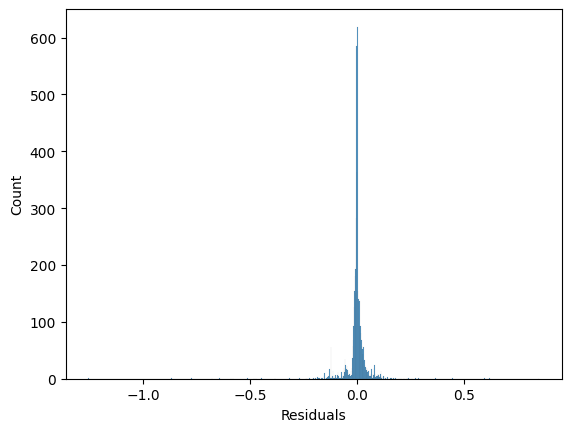

In [9]:
df_imputed = impute_df(df_norm)

#correlation_matrix_heatmap(df_imputed) #Correlation matrix heatmap used for improve_model3 to chose the features

#The functions below combined with minor changes in the data cleaning method were used to explore
#different linear models and find the best performing. Results for all can be found in the report.
#The best performing model is the one being returned with this configuration.
improved_model(df_imputed)
#improved_model2(df_imputed)
#improved_model3(df_imputed)


Plotting elbow method...
2 360.91046240139303
4 227.71030328984332
6 167.72629188657157
8 133.23064692208416
10 109.10072253553366
12 93.97728601787419


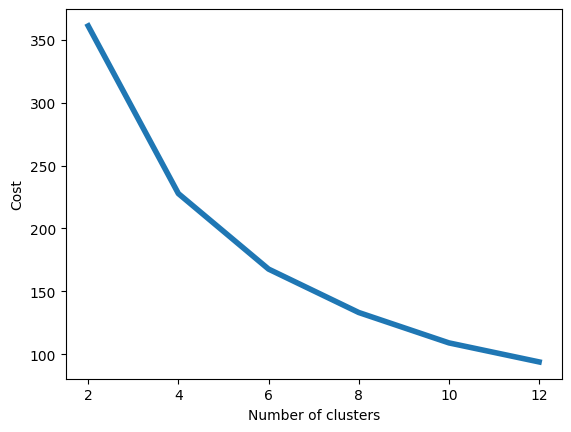

DONE


In [10]:
def cluster(df, labels):
    #Creates a scatterplot showing the clusters
    
    pca_data = PCA().fit(df)
    pca_2d = pca_data.transform(df)
    plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labels)
    plt.title('Clusters')
    plt.show()
    
def elbow(df):
    #Plot elbow meethod graph
    
    print("\nPlotting elbow method...")
    sse = {}
    for k in range(2, 14, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(df)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_  
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()
    print("DONE")

def K_Means(df, k):
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(df)
    labels = model.labels_ #include the labels into the data
    return labels

elbow(df_imputed)

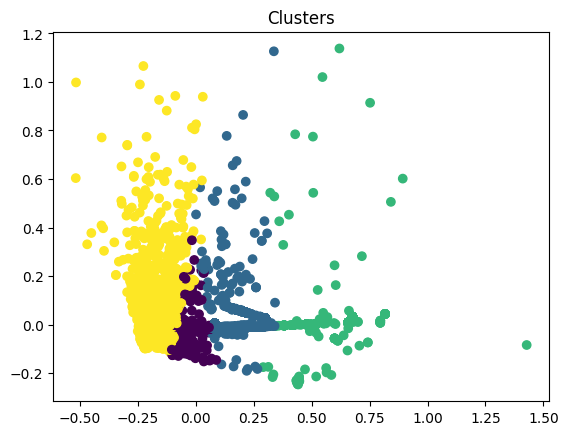

In [15]:
labels = K_Means(df_imputed, 4)   
cluster(df_imputed, labels)

In [20]:
def local_linear_regressor(df):
    #Builds a local linear regressor for each cluster
    
    labels = K_Means(df, 4)
    df_copy = df.copy()
    df_copy['cluster'] = labels.tolist()
    
    rsq = []
    
    for i in range(4):
        temp = df_copy[df_copy['cluster'] == i].copy()
        #improved_model(temp)
        cols = temp.columns.values.tolist()
        cols.remove('LOG_PRICE')
        cols.remove('SALE PRICE')
        Y = temp['LOG_PRICE'] #Column to predict
        X = temp[cols] #Columns used to predict
        trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.5) #Split data into a train set and test set
        lm = linear_model.LinearRegression(n_jobs=-1)
        lm.fit(trainX, trainY) #Train the Linear Regression Model
        crossvalidation = KFold(8,shuffle=True, random_state=0)
        cv = cross_val_score(lm, X, Y,scoring='r2',cv=crossvalidation, n_jobs=-1)
        rsq_val = np.mean(cv)
        rsq.append(rsq_val)
        print('R squared value for cluster {} using cross-validation: {}'.format(i, rsq_val))
    
    print('\nMean of r squared values for local linear regressors: {}\n'.format(np.mean(rsq)))
    print('Minimum and maximum r squared value are: {} & {}\n'.format(min(rsq), max(rsq)))
        

local_linear_regressor(df_imputed)

R squared value for cluster 0 using cross-validation: 0.4150502283503271
R squared value for cluster 1 using cross-validation: 0.2107788184654248
R squared value for cluster 2 using cross-validation: 0.7516527521015863
R squared value for cluster 3 using cross-validation: 0.02742152872042028

Mean of r squared values for local linear regressors: 0.3512258319094396

Minimum and maximum r squared value are: 0.02742152872042028 & 0.7516527521015863

